In [1]:
%reload_ext autoreload
%autoreload 2

import cv2

import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from collections import defaultdict

from matplotlib.path import Path
%matplotlib inline

In [2]:
labels = ['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL' , 'BackG']
label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [3]:
# stack = 'MD589'
# sec = 165

stack = 'MD594'
sec = 289

dm = DataManager(stack=stack, section=sec, segm_params_id='tSLIC200', load_mask=False)

dm._load_image(['rgb'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (167180288 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [4]:
patch_size = 224
half_size = patch_size/2
stride = 56

h, w = dm.image_rgb.shape[:2]

In [5]:
probs = np.load('/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/%(stack)s_%(sec)04d_test_prediction_map.npy' % {'stack':stack, 'sec':sec})

In [6]:
preds = np.argmax(probs, axis=1).astype(np.int)

In [7]:
sample_locations_reduced = np.load('/home/yuncong/CSHL_data_patches/%(stack)s_%(sec)04d_sample_locations_reduced.npy'%{'stack':stack, 'sec':sec})

In [8]:
# MD589_165
# box_x = 43
# box_y = 205
# box_w = 170
# box_h = 143
# xmin = box_x*32
# xmax = (box_x+box_w)*32
# ymin = box_y*32
# ymax = (box_y+box_h)*32

# MD594_289
box_x = 37
box_y = 122
box_w = 393
box_h = 219
xmin = box_x*32
xmax = (box_x+box_w)*32
ymin = box_y*32
ymax = (box_y+box_h)*32

viz = dm.image_rgb[ymin:ymax, xmin:xmax]

In [9]:
from scipy.interpolate import RectBivariateSpline

In [10]:
grids = sample_locations_reduced - (xmin, ymin)

In [11]:
grid_unique_xs = np.unique(grids[:,0])
grid_unique_ys = np.unique(grids[:,1])

In [12]:
sample_xmin = max(0, grid_unique_xs.min() - half_size)
sample_xmax = grid_unique_xs.max() + half_size
sample_ymin = max(0, grid_unique_ys.min() - half_size)
sample_ymax = grid_unique_ys.max() + half_size

print sample_xmin, sample_xmax, sample_ymin, sample_ymax

0 12648 0 7016


In [13]:
dense_grid_ys, dense_grid_xs = np.meshgrid(range(viz.shape[0]), range(viz.shape[1]), indexing='ij')

In [ ]:
from joblib import Parallel, delayed

In [ ]:
def generate_score_map(l):
    
    m = dict(zip([(x,y) for x,y in grids], probs[:, l]))
    m2 = dict(zip([(x,y) for x,y in grids], preds))
    
    score_map = np.zeros((grid_unique_xs.size, grid_unique_ys.size))
    prediction_map = np.zeros((grid_unique_xs.size, grid_unique_ys.size), np.int)
    for xi, x in enumerate(grid_unique_xs):
        for yi, y in enumerate(grid_unique_ys):
            if (x,y) not in m:
                score_map[xi,yi] = 0
                prediction_map[xi,yi] = -1
            else:
                score_map[xi,yi] = m[(x,y)]
                prediction_map[xi,yi] = m2[(x,y)]
                
    spline = RectBivariateSpline(grid_unique_xs, grid_unique_ys, 
                             score_map, 
                             bbox=[0, viz.shape[1], 0, viz.shape[0]])

    dense_score_map = spline.ev(dense_grid_xs.flat, dense_grid_ys.flat).reshape(viz.shape[:2])

    dense_score_map[sample_ymax+1:] = 0.
    dense_score_map[:sample_ymin] = 0.
    dense_score_map[:, sample_xmax+1:] = 0.
    dense_score_map[:, :sample_xmin] = 0.
    
    return dense_score_map

In [ ]:
Parallel(n_jobs=5)(delayed(generate_score_map)(l) for l in range(10))

In [14]:
import time
t = time.time()

dense_score_maps = []

for l in range(10):
    
    print l
    
    m = dict(zip([(x,y) for x,y in grids], probs[:, l]))
    m2 = dict(zip([(x,y) for x,y in grids], preds))
    
    score_map = np.zeros((grid_unique_xs.size, grid_unique_ys.size))
    prediction_map = np.zeros((grid_unique_xs.size, grid_unique_ys.size), np.int)
    for xi, x in enumerate(grid_unique_xs):
        for yi, y in enumerate(grid_unique_ys):
            if (x,y) not in m:
                score_map[xi,yi] = 0
                prediction_map[xi,yi] = -1
            else:
                score_map[xi,yi] = m[(x,y)]
                prediction_map[xi,yi] = m2[(x,y)]
                
    spline = RectBivariateSpline(grid_unique_xs, grid_unique_ys, 
                             score_map, 
                             bbox=[0, viz.shape[1], 0, viz.shape[0]])

    dense_score_map = spline.ev(dense_grid_xs.flat, dense_grid_ys.flat).reshape(viz.shape[:2])

    dense_score_map[sample_ymax+1:] = 0.
    dense_score_map[:sample_ymin] = 0.
    dense_score_map[:, sample_xmax+1:] = 0.
    dense_score_map[:, :sample_xmin] = 0.
    
    dense_score_maps.append(dense_score_map)
    
print time.time() - t

0
1
2
3
4
5
6
7
8
9


In [15]:
dense_sorted_score_map = np.sort(dense_score_maps, axis=0)
dense_top_score_map = dense_sorted_score_map[-1]
dense_second_score_map = dense_sorted_score_map[-2]

In [16]:
dense_prediction_map = np.argsort(dense_score_maps, axis=0)
dense_top_prediction_map = dense_prediction_map[-1]
dense_second_prediction_map = dense_prediction_map[-2]

In [ ]:
# plt.imshow(np.minimum(1., dense_top_score_map - dense_second_score_map), cmap=plt.cm.gray);
# plt.colorbar();

In [ ]:
# plt.imshow(dense_top_score_map - dense_second_score_map < .2, cmap=plt.cm.gray);

In [17]:
dense_top_prediction_map[dense_top_score_map - dense_second_score_map < .2] = label_dict['BackG']

In [29]:
# colors = (np.random.random((10,3)) * 255).astype(np.int)
colors = (np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')*255).astype(np.uint8)
colors[label_dict['BackG']] = 255

In [31]:
dense_prediction_map_overlay = colors[dense_top_prediction_map].astype(np.uint8)

In [ ]:
# display(dense_prediction_map_overlay)

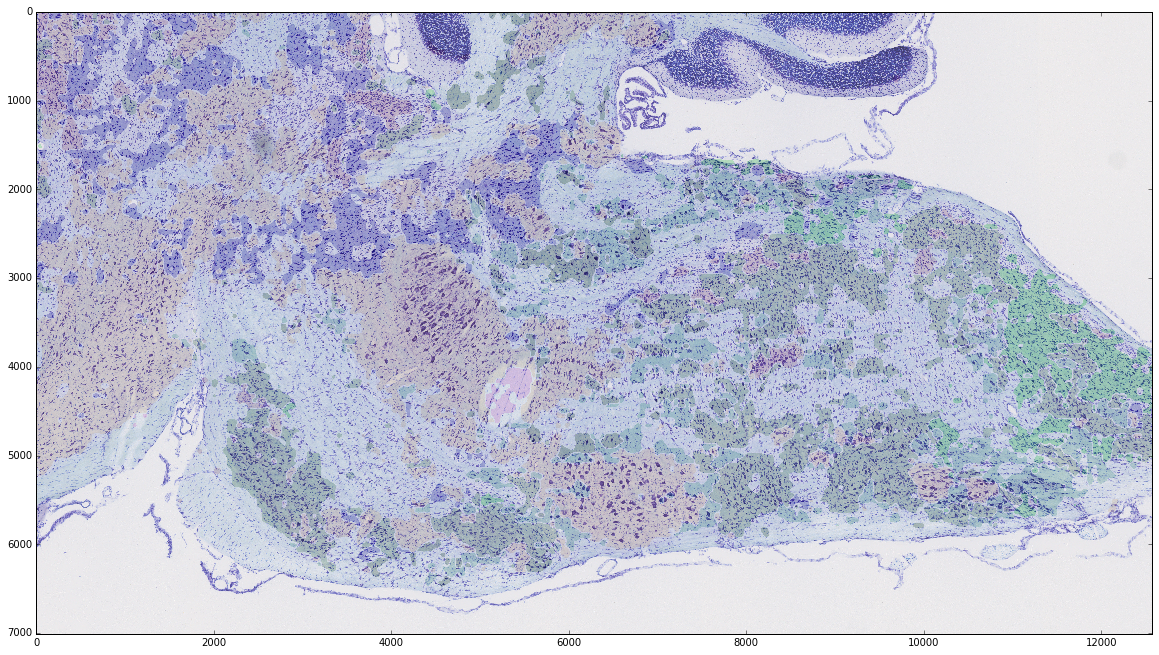

In [32]:
viz2 = alpha_blending(dense_prediction_map_overlay[...,:3], img_as_ubyte(viz), .2, 1.,)
plt.figure(figsize=(20,20));
plt.imshow(viz2);

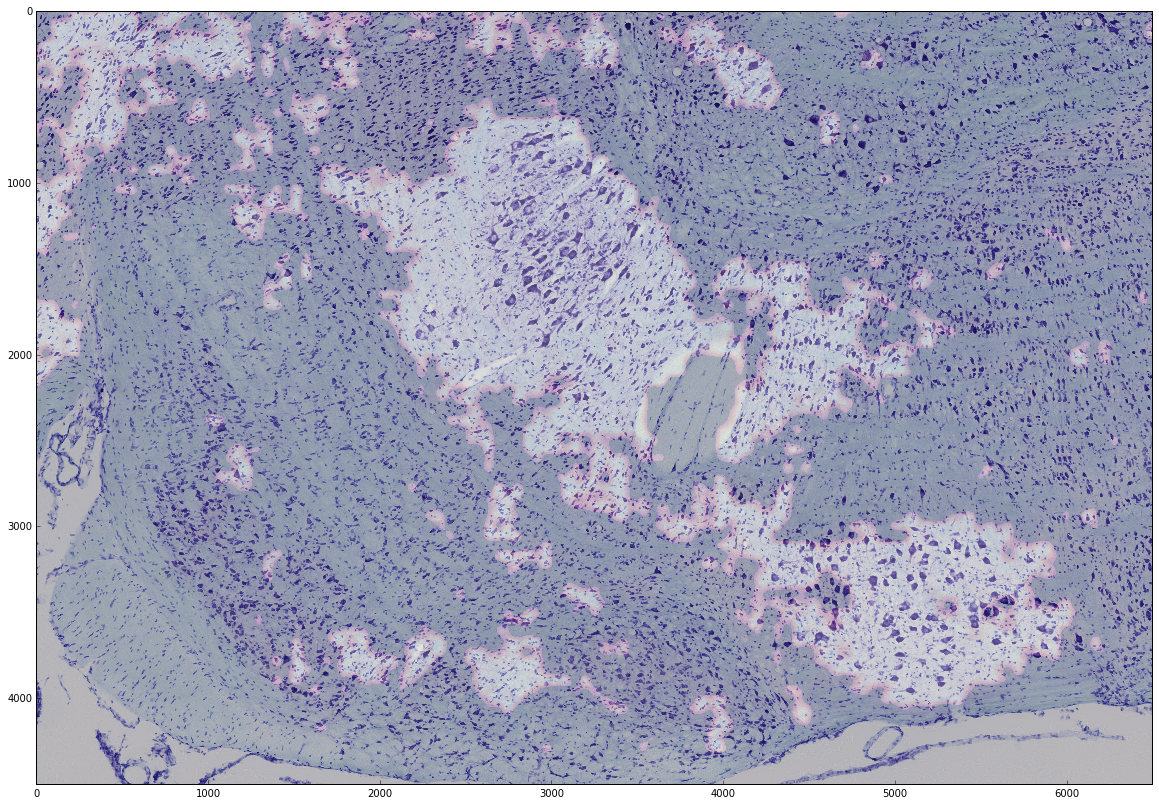

In [24]:
plt.figure(figsize=(20,20));
plt.imshow(viz2[2000:6500, 1500:8000]);

In [21]:
dense_score_map = dense_score_maps[label_dict['5N']]

dense_score_map[dense_score_map > 1] = 1
dense_score_map[dense_score_map < 0.5] = 0

In [22]:
prob_map_viz = img_as_ubyte(plt.cm.magma(dense_score_map)[...,:3])

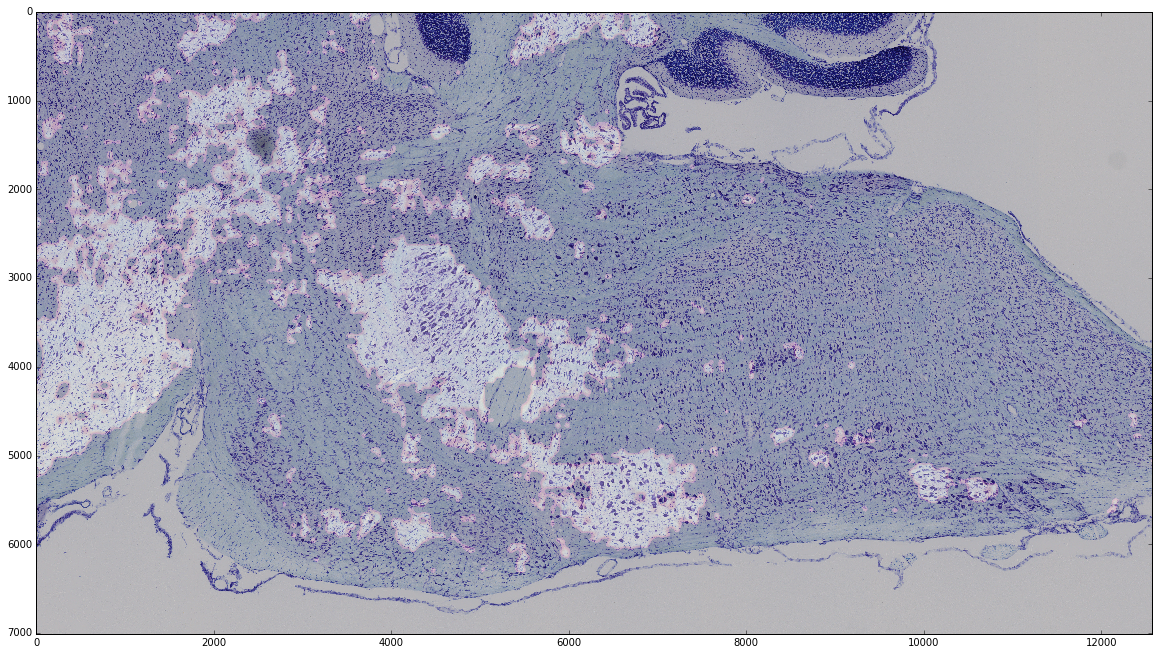

In [23]:
viz2 = alpha_blending(prob_map_viz[...,:3], img_as_ubyte(viz), .2, 1.,)
plt.figure(figsize=(20,20));
plt.imshow(viz2);